In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

SEED = 42

In [64]:
df = pd.read_csv("Housing.csv")

In [65]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [66]:
#DATA CLEANING
#1. No NaN data in this dataframe
print("NaN presence in data")
print(df.isna().sum())

#2. Duplicates in the dataframe
df = df.drop_duplicates()
print("\nDropped duplicates in the data")

NaN presence in data
price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

Dropped duplicates in the data


In [67]:
#3. Converting categorical data into numerical data
# 2 common options to do this - Label Encoding (used when the order of categories matter) and One-Hot Encoding (used when order of categories does not matter)

cols_to_convert = ["mainroad","guestroom","basement","hotwaterheating","airconditioning","prefarea","furnishingstatus"]

one_hot_encoder = OneHotEncoder(sparse_output=False)
for col in cols_to_convert:
    encoded_col = one_hot_encoder.fit_transform(df[[col]]) #[[]] to make the input 2D
    encoded_df = pd.DataFrame(encoded_col, columns=one_hot_encoder.get_feature_names_out([col]), index=df.index)
    df = pd.concat([df.drop(col, axis=1), encoded_df], axis=1)

In [68]:
#4. Convert to X and y
X = df[['area','bedrooms','bathrooms','stories','parking','mainroad_no','mainroad_yes','guestroom_no','guestroom_yes',
       'basement_no','basement_yes','hotwaterheating_no','hotwaterheating_yes','airconditioning_no','airconditioning_yes',
       'prefarea_no','prefarea_yes','furnishingstatus_furnished',
       'furnishingstatus_semi-furnished','furnishingstatus_unfurnished']]

y = df['price']

In [69]:
#5. Feature scale/normalize the data to bring them to a similar scale.
# 2 common options - MinMaxScaling (scaling for a range [0,1]) and StandardScaler (Z-score scaling where 0 is mean + 1 SD)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [70]:
#6. Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.10, random_state=SEED)

In [71]:
#OPTIONAL - could do a feature engineering to create new features or manipulate existing features (in this, data is quite clean)

In [74]:
#7. Build a simple model on this data
#7.1 Linear Regression

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")  #Lower the better
print(f"MSE: {mse:.2f}") #Lower the better
print(f"RMSE: {rmse:.2f}") #Lower the better
print(f"R-squared (R²): {r2:.2f}") #Closer to 1, the better

MAE: 875812.70
MSE: 1451838962597.81
RMSE: 1204922.80
R-squared (R²): 0.69


In [75]:
#7.2 XGBoost (Extreme Gradient Boosting)

model = xgb.XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")  #Lower the better
print(f"MSE: {mse:.2f}") #Lower the better
print(f"RMSE: {rmse:.2f}") #Lower the better
print(f"R-squared (R²): {r2:.2f}") #Closer to 1, the better

MAE: 1045233.39
MSE: 2050139855394.03
RMSE: 1431830.95
R-squared (R²): 0.56


In [85]:
#7.3 XGBoost (Extreme Gradient Boosting) + GridSearchCV

# Define the parameters we want to explore - this goes into grid searching later
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

model = xgb.XGBRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best parameters from grid :", best_params)
# OPTIONAL - explore further parameter grids before and after these parameters (in order to find the better minima)

# Train the model with the best hyperparameters
best_xgb_model = xgb.XGBRegressor(**best_params)
best_xgb_model.fit(X_train, y_train)

# Make predictions and evaluate the best model
y_pred_best = best_xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_best)
mse = mean_squared_error(y_test, y_pred_best)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_best)

print(f"MAE: {mae:.2f}")  #Lower the better
print(f"MSE: {mse:.2f}") #Lower the better
print(f"RMSE: {rmse:.2f}") #Lower the better
print(f"R-squared (R²): {r2:.2f}") #Closer to 1, the better

Best parameters from grid : {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}
MAE: 961154.14
MSE: 1801875749668.97
RMSE: 1342339.66
R-squared (R²): 0.61


In [96]:
#7.3 Polynomial Regression (Using Linear Regression + Polynomial features)

degree = 2  #1 = Linear Regression + Linear features,2 = quadratic, 3 = cubic relationship with the target, 
polynomial_features = PolynomialFeatures(degree=degree)
X_train_poly = polynomial_features.fit_transform(X_train)
X_test_poly = polynomial_features.transform(X_test)

model = LinearRegression()
model.fit(X_train_poly, y_train)

y_pred = model.predict(X_test_poly)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")  #Lower the better
print(f"MSE: {mse:.2f}") #Lower the better
print(f"RMSE: {rmse:.2f}") #Lower the better
print(f"R-squared (R²): {r2:.2f}") #Closer to 1, the better

MAE: 1017881.82
MSE: 1910168749475.20
RMSE: 1382088.55
R-squared (R²): 0.59


ValueError: x and y must be the same size

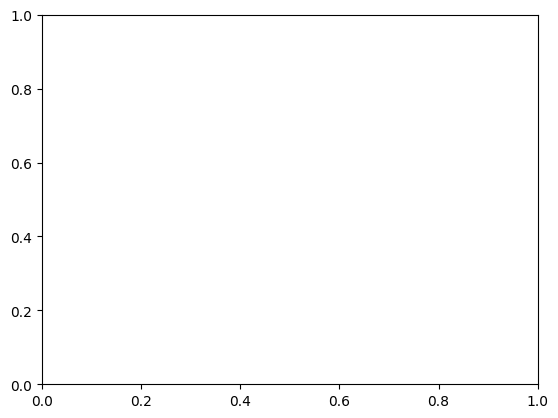

In [97]:
plt.scatter(X_test, y_test, color='blue', label='Actual Data')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Polynomial Regression')
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.legend()
plt.show()